In [1]:
import utils 

from utils import *

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline


### Load Data

In [3]:
train = pd.read_json("data/input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("data/input/test.json")


In [ ]:
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')


In [ ]:
X_angle=train['inc_angle']
X_test_angle=test['inc_angle']

In [5]:
# sample_weights = {0:}

In [6]:
test.shape

(8424, 4)

In [7]:
test.shape[0]/8.

1053.0

### Preprocess

In [8]:
from scipy import signal
from tqdm import tqdm_notebook
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

In [61]:

#Generate the training data
# X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
# X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

def get_bands(train):
    X_band_1 = []
    X_band_2 = []
    X_band_3 = [] 

    for i in tqdm_notebook(range(train.shape[0])):

        b1_arrx = signal.convolve2d(np.reshape(np.array(train.loc[i,"band_1"]).astype(np.float32),(75,75)),xder,mode='valid')
        b1_arry = signal.convolve2d(np.reshape(np.array(train.loc[i,"band_1"]).astype(np.float32),(75,75)),yder,mode='valid') # xder > yder
    #     print b1_arrx.mean(), b1_arry.mean()

        X_band_1.append(np.hypot(b1_arrx,b1_arry))

        b2_arrx = signal.convolve2d(np.reshape(np.array(train.loc[i,"band_2"]).astype(np.float32),(75,75)),xder,mode='valid')
        b2_arry = signal.convolve2d(np.reshape(np.array(train.loc[i,"band_2"]).astype(np.float32),(75,75)),yder,mode='valid') # xder > yder
        X_band_2.append(np.hypot(b2_arrx,b2_arry))

        X_band_3.append((X_band_1[i]+X_band_2[i])/2.)

    X_band_1 =  np.array(X_band_1)
    X_band_2 =  np.array(X_band_2)
    X_band_3 =  np.array(X_band_3)
    
    #exp: use original band1 and 2 as dims 0 and 1
    X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
    X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

    # #X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
#     print X_band_1.shape,X_band_2.shape,X_band_3.shape
    X_train = np.concatenate([X_band_1[:, 1:-1,1:-1, np.newaxis]
                              , X_band_2[:, 1:-1,1:-1, np.newaxis]
                             , X_band_3[:, :, :, np.newaxis]], axis=-1)


    return X_train

# X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
# X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
# X_band_test_3=(X_band_test_1+X_band_test_2)/2
# #X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
# X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
#                           , X_band_test_2[:, :, :, np.newaxis]
#                          , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [62]:
%time X_train = get_bands(train)

A Jupyter Widget


CPU times: user 4.1 s, sys: 96 ms, total: 4.2 s
Wall time: 4.12 s


In [70]:
%time X_test = get_bands(test)

A Jupyter Widget


CPU times: user 21.6 s, sys: 800 ms, total: 22.4 s
Wall time: 22.1 s


In [25]:
X_test.shape

(8424, 73, 73, 3)

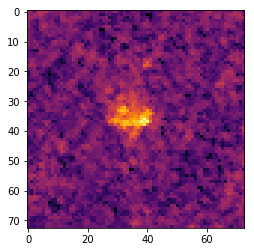

In [69]:
plt.imshow(X_train[1200,:,:,0],cmap='inferno')

### Train Model 

In [71]:


batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [72]:

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, patience=5):
    es = EarlyStopping('val_loss', patience=5, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
#     lrplateu = ReduceLROnPlateau(monitor='val_loss',  patience=2, verbose=1, factor=0.5, min_lr=1e-6)

    return [es, msave]


In [73]:
def getModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = Flatten()(x) #GlobalMaxPooling2D
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(input=[base_model.input, input_2], output=predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model


In [74]:


#Using K-fold Cross Validation with Data Augmentation.
def trainKfold(X_train, X_angle, X_test):
    K=3
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=17).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    
    
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j+1)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        
        #Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = "weights/{}_{}.hdf5".format(exp_name,j+1)
        callbacks = get_callbacks(filepath=file_path, patience=5)
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        
        model= getModel()
        model.fit_generator(
                gen_flow,
                steps_per_epoch=24,
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data=([X_holdout,X_angle_hold], Y_holdout),
                callbacks=callbacks)

        #Getting the Best Model
        model.load_weights(filepath=file_path)
        #Getting Training Score
        score = model.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        
        #Getting Test Score
        score = model.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=model.predict([X_holdout,X_angle_hold])
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores

        temp_test=model.predict([X_test, X_test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])
        


        #Getting Train Scores
        temp_train=model.predict([X_train, X_angle])
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    
    train_log_loss = log_loss(target_train, y_train_pred_log) 
    valid_log_loss = log_loss(target_train, y_valid_pred_log)
    
    print('\n Train Log Loss Validation= ',train_log_loss)
    print(' Valid Log Loss Validation= ',valid_log_loss)
    
    
    return y_train_pred_log, y_valid_pred_log, y_test_pred_log, train_log_loss, valid_log_loss





In [75]:
exp_name = "_3ch3gradavg"
train_preds , val_preds, test_preds, train_log_loss,valid_log_loss = trainKfold(X_train, X_angle, X_test)

('\n===================FOLD=', 1)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


Epoch 1/100
24/24 [==============================] - 14s - loss: 0.7574 - acc: 0.5529 - val_loss: 0.5338 - val_acc: 0.6710
Epoch 2/100
24/24 [==============================] - 13s - loss: 0.4932 - acc: 0.7551 - val_loss: 0.4116 - val_acc: 0.8037
Epoch 3/100
24/24 [==============================] - 13s - loss: 0.4495 - acc: 0.8004 - val_loss: 0.3717 - val_acc: 0.8262
Epoch 4/100
24/24 [==============================] - 13s - loss: 0.3997 - acc: 0.8399 - val_loss: 0.3633 - val_acc: 0.8411
Epoch 5/100
24/24 [==============================] - 13s - loss: 0.3777 - acc: 0.8382 - val_loss: 0.3423 - val_acc: 0.8467
Epoch 6/100
24/24 [==============================] - 13s - loss: 0.3930 - acc: 0.8261 - val_loss: 0.3376 - val_acc: 0.8449
Epoch 7/100
24/24 [==============================] - 13s - loss: 0.3104 - acc: 0.8671 - val_loss: 0.3079 - val_acc: 0.8617
Epoch 8/100
24/24 [==============================] - 13s - loss: 0.3136 - acc: 0.8639 - val_loss: 0.2771 - val_acc: 0.8561
Epoch 9/100
24/2

24/24 [==============================] - 13s - loss: 0.2335 - acc: 0.8978 - val_loss: 0.2446 - val_acc: 0.8858
Epoch 22/100
24/24 [==============================] - 13s - loss: 0.2469 - acc: 0.8902 - val_loss: 0.2494 - val_acc: 0.8914
Epoch 23/100
24/24 [==============================] - 13s - loss: 0.2560 - acc: 0.8894 - val_loss: 0.2245 - val_acc: 0.9082
Epoch 24/100
24/24 [==============================] - 13s - loss: 0.2393 - acc: 0.8948 - val_loss: 0.2547 - val_acc: 0.9064
Epoch 25/100
24/24 [==============================] - 13s - loss: 0.2213 - acc: 0.9137 - val_loss: 0.2237 - val_acc: 0.9082
Epoch 26/100
24/24 [==============================] - 13s - loss: 0.2118 - acc: 0.9183 - val_loss: 0.2326 - val_acc: 0.9101
('Train loss:', 0.21642523976129907)
('Train accuracy:', 0.90747663595966088)
('Test loss:', 0.22260746516091992)
('Test accuracy:', 0.9044943831386637)
('\n Train Log Loss Validation= ', 0.18046839225744929)
(' Valid Log Loss Validation= ', 0.23097930139509801)


In [76]:
pickle.dump(file=open("cache/{}_tmp_results.dmp".format(exp_name),"wb"), obj=[train_preds , val_preds, test_preds, train_log_loss,valid_log_loss])


In [62]:
train_preds , val_preds, test_preds, train_log_loss, valid_log_loss = pickle.load(file=open("tmp_results.dmp","rb"))


    

### TTA


In [ ]:
def make_TTA_preds(exp_name):

    K=3
    y_test_pred_log = 0
    
    

    def gen_flow_for_two_inputs_test(test_gen, X1, X2):
        genX2 = test_gen.flow(X1,X2, batch_size=8,shuffle=False)
        while True:
                X2i = genX2.next()
                yield [X2i[0], X2i[1]]

    partials = []
    
    
    for j in range(K):
        print('\n===================FOLD=',j+1)
        
        model= getModel()

        #Getting the Best Model
        model.load_weights("weights/{}_{}.hdf5".format(exp_name,j+1))
        #Getting Training Score

        
        test_gen = ImageDataGenerator(horizontal_flip = True,
                                      vertical_flip = True, 
                                      width_shift_range = 0.,  
                                      height_shift_range = 0.,      
                                      channel_shift_range=0,        
                                      zoom_range = 0.2,         
                                      rotation_range = 10)   


        preds = np.zeros((test.shape[0],1)).astype(np.float32) 

        num_aug = 5
        for i in range(num_aug):
            gen_flow_test = gen_flow_for_two_inputs_test(test_gen, X_test, X_test_angle)
            preds += model.predict_generator(gen_flow_test,steps=test.shape[0]/8, verbose=1).reshape(-1,1)


        partials.append(preds/num_aug)    
        temp_test=preds/num_aug
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])                           
                           

    y_test_pred_log=y_test_pred_log/K


    
    return y_test_pred_log, partials


    
tta_preds_3fold_baseline,partials = make_TTA_preds("_3fold_baseline")    


### Submission

In [77]:

def update_results_h5(phase, exp_name, train_id, test_id, train_preds, val_preds,test_preds, train_log_loss,valid_log_loss, LB_score=0.0):
		
		train_preds  = pd.DataFrame(data={"is_iceberg":train_preds})
		train_preds["id"]=train_id.astype(str)
		train_preds.set_index("id",inplace=True)

		
		
		val_preds  = pd.DataFrame(data={"id":train['id'],"is_iceberg":val_preds})
		val_preds["id"]=train_id.astype(str)
		val_preds.set_index("id",inplace=True)
		
		
		
		submission = pd.DataFrame()
		submission['id']=test_id
		submission['is_iceberg']=test_preds
		submission.to_csv('subm/{}.csv'.format(exp_name), index=False)

		submission['id']=test['id'].astype(str)
		submission.set_index("id",inplace=True)


		
		train_preds.to_hdf('data/results.h5',"/{}/train/{}".format(phase,exp_name))
		val_preds.to_hdf('data/results.h5',"/{}/valid/{}".format(phase,exp_name))
		submission.to_hdf('data/results.h5',"/{}/test/{}".format(phase,exp_name))



		

		store = pd.HDFStore('data/results.h5')

		store.append("/summary",pd.DataFrame(data={"phase":[phase],
																							 "exp":[exp_name],
																							 "train_log_loss":[train_log_loss],
																							 "val_log_loss":[valid_log_loss], 
																							 "LB":[LB_score] }) )  

		store.close()

In [78]:
update_results_h5("ph1", exp_name, train["id"], test["id"], 
                  train_preds, val_preds,test_preds, train_log_loss,valid_log_loss, LB_score=0. )

In [63]:
train_preds  = pd.DataFrame(data={"is_iceberg":train_preds})
train_preds["id"]=train['id'].astype(str)
train_preds.set_index("id",inplace=True)




In [45]:
### Submissionval_preds  = pd.DataFrame(data={"id":train['id'],"is_iceberg":val_preds})
val_preds["id"]=train['id'].astype(str)
val_preds.set_index("id",inplace=True)

In [25]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id'].astype(str)
submission['is_iceberg']= tta_preds_3fold_baseline
submission.to_csv('subm/{}.csv'.format("_3f_tta"), index=False)

submission.set_index("id",inplace=True)

In [2]:
import pandas as pd 

In [3]:
store = pd.HDFStore('data/results.h5')


In [45]:
np.corrcoef(store.select("/ph1/valid/_5fold_baseline").values.ravel(), store.select("/ph1/train/_5fold_baseline").values.ravel())

array([[ 1.        ,  0.80484443],
       [ 0.80484443,  1.        ]])

In [8]:
store.close()

In [4]:
store.keys()

['/summary',
 '/ph1/test/_3f_aug0_1',
 '/ph1/test/_3f_imgstats',
 '/ph1/test/_3f_xception',
 '/ph1/test/_3fmax_tflat',
 '/ph1/test/_3fold_1xconvs',
 '/ph1/test/_3fold_1xconvs_nobninthestart',
 '/ph1/test/_3fold_baseline',
 '/ph1/test/_5fold_baseline',
 '/ph1/test/_5fold_fcn',
 '/ph1/train/_3f_aug0_1',
 '/ph1/train/_3f_imgstats',
 '/ph1/train/_3f_xception',
 '/ph1/train/_3fmax_tflat',
 '/ph1/train/_3fold_1xconvs',
 '/ph1/train/_3fold_1xconvs_nobninthestart',
 '/ph1/train/_3fold_baseline',
 '/ph1/train/_5fold_baseline',
 '/ph1/train/_5fold_fcn',
 '/ph1/valid/_3f_aug0_1',
 '/ph1/valid/_3f_imgstats',
 '/ph1/valid/_3f_xception',
 '/ph1/valid/_3fmax_tflat',
 '/ph1/valid/_3fold_1xconvs',
 '/ph1/valid/_3fold_1xconvs_nobninthestart',
 '/ph1/valid/_3fold_baseline',
 '/ph1/valid/_5fold_baseline',
 '/ph1/valid/_5fold_fcn']

In [7]:
store.get('/ph1/test/_3fold_baseline').reset_index().to_csv("subm/_3fold_baseline.csv",index=False)

In [82]:
benchmark3cv = pd.read_csv("subm/sub_benchmark.csv")

In [84]:
benchmark3cv.set_index('id',inplace=True)

In [92]:
benchmark3cv.join(store.get("/ph1/test/_5fold_baseline"),lsuffix="_3cv").corr()

,is_iceberg_3cv,is_iceberg
is_iceberg_3cv,1.000000,0.975071
is_iceberg,0.975071,1.000000
